!pip install lassonet

!pip install tqdm_joblib

In [1]:
import sys
!{sys.executable} --version

Python 3.8.5


In [48]:
########## save survival data for experiments in R ###############

In [30]:
import sksurv
import sksurv.datasets as dt

x_cancer, y_cancer = dt.load_breast_cancer()
pd.DataFrame(y_cancer).to_csv("y_cancer_sksurv.csv")
x_cancer.to_csv("x_cancer_sksurv.csv")

x_cancer, y_cancer = dt.load_whas500()
pd.DataFrame(y_cancer).to_csv("y_whas500_sksurv.csv")
x_cancer.to_csv("x_whas500_sksurv.csv")

In [47]:
########################################################

In [2]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from pathlib import Path
from lassonet import LassoNetClassifierCV, LassoNetCoxRegressor, LassoNetCoxRegressorCV, plot_path, plot_cv
from lassonet.utils import confidence_interval
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold

In [3]:
import lifelines
from lifelines.utils import concordance_index

In [4]:
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib

In [49]:
# HNSCC data

In [98]:
X = pd.read_csv("x.csv")
y = pd.read_csv("y.csv")

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0,stratify = y.iloc[:,1])

In [7]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [8]:
print(y_train[:,1].mean(), y_test[:,1].mean(), y.iloc[:,1].mean())

0.1242603550295858 0.12389380530973451 0.12416851441241686


#### LassoNetCoxRegression with no CV (a path with all lambdas from lambda_start, with step *path_multiplier 

In [9]:
model = LassoNetCoxRegressor(
    hidden_dims=(100,),
    lambda_start=10,
    path_multiplier=1.02,
    gamma=1,
    verbose=True,
    tie_approximation="breslow"
)

In [10]:
path = model.path(X_train, y_train)

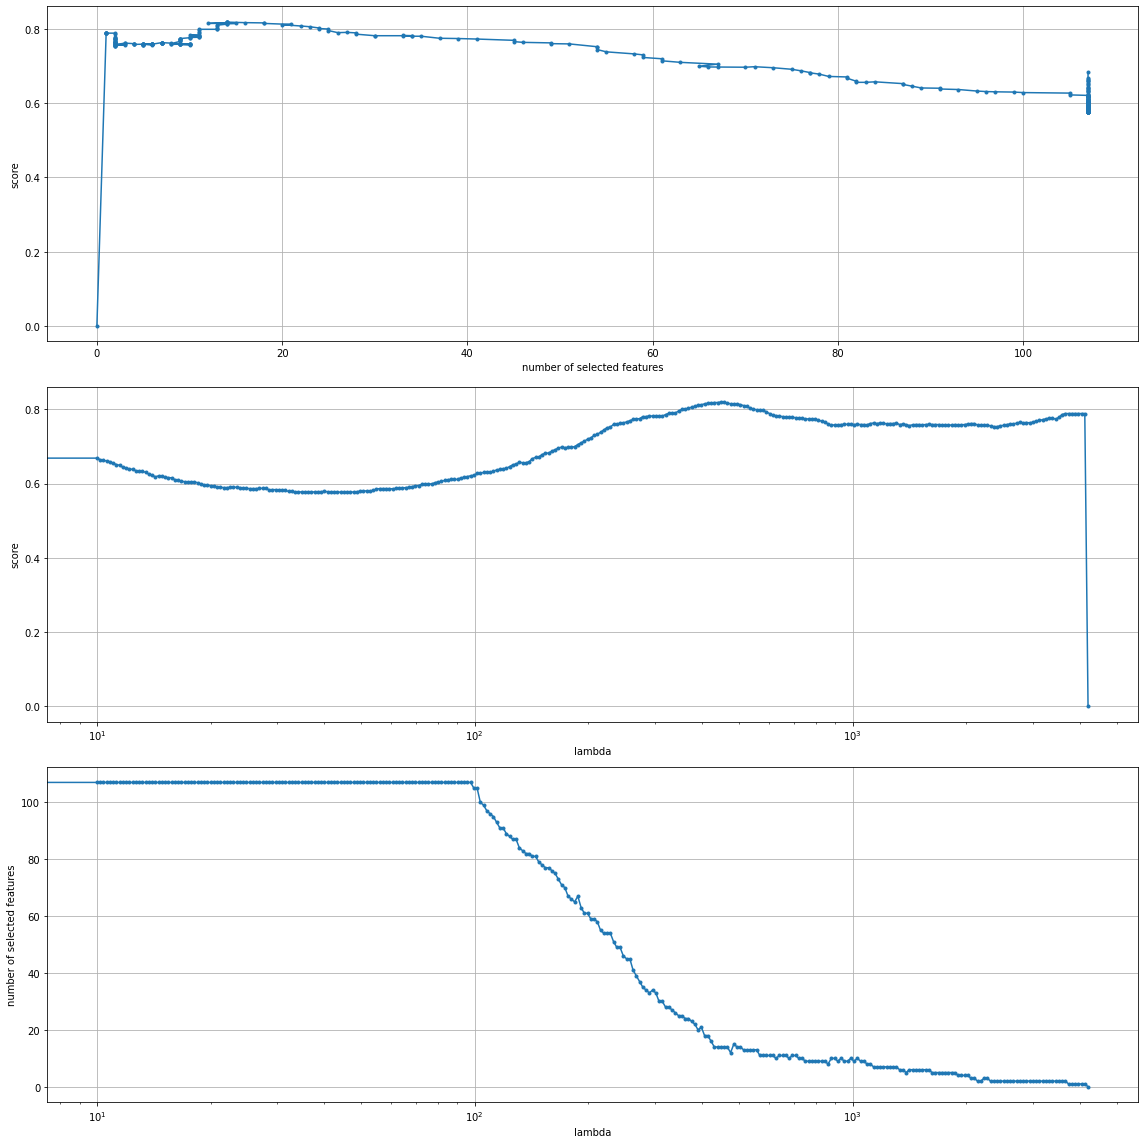

In [11]:
plot_path(model, path, np.array(X_test), np.array(y_test))

In [12]:
a = [path[i].lambda_ for i in range(len(path))]
np.round(a[1:25],3)

array([10.   , 10.2  , 10.404, 10.612, 10.824, 11.041, 11.262, 11.487,
       11.717, 11.951, 12.19 , 12.434, 12.682, 12.936, 13.195, 13.459,
       13.728, 14.002, 14.282, 14.568, 14.859, 15.157, 15.46 , 15.769])

#### END -------------------------------------------------- of LassoNetCoxRegression

### Lasso net with CV-ed lambda

In [114]:
cv = list(StratifiedKFold(n_splits=2, shuffle=True, random_state=42).split(X_train, y_train[:, 1]))

model_cv = LassoNetCoxRegressorCV(
        tie_approximation="breslow",
        hidden_dims = (16,16),
        path_multiplier=1.02,
        cv=cv,
        torch_seed=42,
        verbose=True,
        lambda_start = 100,
    )

In [115]:
pathcv = model_cv.path(X_train, y_train)

Choosing lambda with cross-validation:   0%|          | 0/2 [00:00<?, ?it/s]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=100.000 might be too large.
Features start to disappear at current_lambda=102.000.
  warnings.warn(
Choosing lambda with cross-validation: 100%|██████████| 2/2 [00:21<00:00, 10.99s/it]


In [116]:
# plot_cv(model_cv, X_test, y_test) #uncomment for plots 
print("Lambda =", model_cv.best_lambda_)

best_cv_cscore = model_cv.score(X_test, y_test)
print("Best model scored", best_cv_cscore)

Lambda = 2840.7239170473704
Best model scored 0.7729468599033816


In [117]:
from lifelines.utils import concordance_index

In [118]:
concordance_index(y_test[:,0], -1*model_cv.predict(X_test).flatten(), y_test[:,1])

0.7729468599033816

#### END -------------------------------------------------- of Lasso net with CV-ed lambda

### Nested CV with Lasso Net

In [199]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold,RepeatedStratifiedKFold

In [200]:
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

In [204]:
for (a,b) in outer_cv.split(X.iloc[:20,:], y = np.random.binomial(1,0.5, 20)):
    print (b)

[ 2  3 10 11]
[ 7  8 15 18]
[ 6 13 16 19]
[ 1  5  9 12]
[ 0  4 14 17]
[ 2  5 16 19]
[11 15 17 18]
[ 1  3  9 13]
[ 6  7  8 10]
[ 0  4 12 14]
[ 8  9 10 18]
[ 3  5 13 16]
[ 1  2  4 14]
[ 6 11 17 19]
[ 0  7 12 15]
[ 6  8 11 15]
[ 3 12 14 19]
[ 4  9 16 18]
[ 1  2  5 17]
[ 0  7 10 13]
[ 1  4  5 19]
[ 0 12 14 15]
[ 2  7 10 11]
[ 6  8 17 18]
[ 3  9 13 16]


In [203]:
for (train_index, test_index) in outer_cv.split(X, y.iloc[:,1]):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train_i, X_test_i = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train_i, y_test_i = y.iloc[train_index, :], y.iloc[test_index, :]
   
    inner_cv_i = inner_cv.split(np.array(X_train_i), np.array(y_train_i)[:,1])
    
    model_cv_i = LassoNetCoxRegressorCV(tie_approximation="breslow",
        hidden_dims = (16,),
        path_multiplier=1.10,
        cv=inner_cv_i,
        torch_seed=42,
        verbose=True,
        lambda_start = 50,
    )
    
    pathcv_i = model_cv_i.path(np.array(X_train_i), np.array(y_train_i))
    best_cv_cscore_i = model_cv_i.score(np.array(X_train_i), np.array(y_train_i))
    #survpredict_i = model_cv_i.predict(X_test_i).flatten()
    #best_cv_cscore_i = concordance_index(y_test_i[:,0], 1-survpredict_i, y_test_i[:,1])
    
    print("Lambda =", model_cv_i.best_lambda_)
    print("Best model scored", best_cv_cscore_i)
    


Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:  40%|████      | 2/5 [00:12<00:18,  6.08s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 655.499709574998
Best model scored 0.720526998429927


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:  40%|████      | 2/5 [00:11<00:17,  5.85s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 336.37499746628055
Best model scored 0.7602441150828247


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=80.526.
  warnings.warn(
Choosing lambda with cross-validation:  20%|██        | 1/5 [00:05<00:23,  5.89s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 370.0124972129086
Best model scored 0.7430309512667959


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:  40%|████      | 2/5 [00:12<00:18,  6.12s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 305.7954522420732
Best model scored 0.7754581459354233


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:  20%|██        | 1/5 [00:05<00:23,  5.86s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 252.72351424964725
Best model scored 0.8035941795748676


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:  40%|████      | 2/5 [00:11<00:17,  5.91s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 959.7171247887549
Best model scored 0.7189407971461892


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:  20%|██        | 1/5 [00:05<00:23,  5.84s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 336.37499746628055
Best model scored 0.7756689692173563


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 872.4701134443226
Best model scored 0.7522206638616176


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:  20%|██        | 1/5 [00:06<00:24,  6.03s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=60.500.
  warnings.warn(
Choosing lambda with cross-validation:  40%|████      | 2/5 [00:11<00:17,  5.99s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 229.74864931786112
Best model scored 0.781266810112964


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:  60%|██████    | 3/5 [00:17<00:11,  5.80s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 252.72351424964725
Best model scored 0.7466301881756305


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:  40%|████      | 2/5 [00:11<00:17,  5.97s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 1700.1974293078922
Best model scored 0.6698663009941721


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:  20%|██        | 1/5 [00:05<00:23,  5.82s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 142.65583530550015
Best model scored 0.8240883238541318


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:  20%|██        | 1/5 [00:05<00:23,  5.93s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:  60%|██████    | 3/5 [00:17<00:11,  5.87s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=60.500.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 793.1546485857477
Best model scored 0.7485458313832988


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:  60%|██████    | 3/5 [00:17<00:11,  5.85s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 1700.1974293078922
Best model scored 0.74654686871396


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=80.526.
  warnings.warn(
Choosing lambda with cross-validation:  20%|██        | 1/5 [00:05<00:22,  5.60s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:  40%|████      | 2/5 [00:11<00:17,  5.68s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 172.6135607196552
Best model scored 0.7828969396638318


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:  40%|████      | 2/5 [00:11<00:17,  5.86s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 1545.6340266435382
Best model scored 0.7190263969832019


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:  20%|██        | 1/5 [00:05<00:23,  5.85s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=80.526.
  warnings.warn(
Choosing lambda with cross-validation:  60%|██████    | 3/5 [00:17<00:11,  5.89s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 189.87491679162073
Best model scored 0.7532936534474687


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 252.72351424964725
Best model scored 0.7959456747173346


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:  80%|████████  | 4/5 [00:24<00:06,  6.04s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 793.1546485857477
Best model scored 0.7332931161606006


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:  80%|████████  | 4/5 [00:24<00:06,  6.10s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 655.499709574998
Best model scored 0.7518933047382883


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:  20%|██        | 1/5 [00:06<00:24,  6.06s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 721.0496805324979
Best model scored 0.7052950492322523


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:  20%|██        | 1/5 [00:06<00:24,  6.12s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 959.7171247887549
Best model scored 0.7021105527638191


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:  20%|██        | 1/5 [00:05<00:23,  5.85s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=80.526.
  warnings.warn(
Choosing lambda with cross-validation:  40%|████      | 2/5 [00:11<00:17,  5.86s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 541.7352971694197
Best model scored 0.7282040980313379


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:  20%|██        | 1/5 [00:06<00:24,  6.11s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Lambda = 370.0124972129086
Best model scored 0.7512198382461065


C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=73.205.
  warnings.warn(
Choosing lambda with cross-validation:  20%|██        | 1/5 [00:05<00:23,  6.00s/it]C:\Users\dinab\Anaconda3\lib\site-packages\lassonet\interfaces.py:481: UserWarning: lambda_start=50.000 might be too large.
Features start to disappear at current_lambda=66.550.
  warnings.warn(
Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:30<00:00,  6.10s/it]


Lambda = 793.1546485857477
Best model scored 0.7672431060960139


In [264]:
len(pathcv_i)

31

### Nested CV for LassoNet for simulated datasets

* Cross-terms data

In [239]:
def simulated_crossterms (N = 1000, observe_time = 10, percentcensored = 0, randomseed = 100):
    # N - population size
    # observe_time - total observation time, after which all survivors are right-censored 
    # percentcensored - rate of dropping out early from the observation
    # this censoring is applied unformly from 0 to 10, so for those who had the event before dropping out, 
    # would not be censored in terms of the censoring definition, and actual drop out rate <= percentcencored
    #randomseed - random seed for population simulation, set before applying numpy.random functions
    
    #check that inputs are of the right type
    c1 = isinstance(N,int)
    c2 = (isinstance(observe_time, float)|isinstance(observe_time, int))
    c3 = (isinstance(percentcensored, float)|isinstance(percentcensored, int))
    if (isinstance(percentcensored, float)|isinstance(percentcensored, int)): 
        if((percentcensored>=1)|(percentcensored<0)): 
            c3= False
    c4 = isinstance(randomseed,int)
    if (c1&c2&c3&c4 == False): 
        c= [c1,c2,c3,c4] 
        b = ["N", "observe_time", "percentcensored", "randomseed"]
        print ("Error with input type:", [b[i] for i in range(len(c)) if c[i]==False])
        return None 
    
    #start simulations 
    random.seed(randomseed)
    
    #1_ generating main features:
    df = pd.DataFrame({"age": np.round(np.random.uniform(-1.73,1.73,N),1),
                  "bmi": np.round(np.random.normal(0, 1,N),1),  
                  "hyp": np.random.binomial(1,0.20, N),
                  "gender": np.random.binomial(1,0.5, N)})
    
    #2_ generating event times: 
    #BMI impact is 2 for very low and high levels, 1 for high/ low level, 0 for normal range
    bmi_beta = np.array([2 if (np.abs(x)> 1.5) else 1 if (np.abs(x)>1) else 0 for x in df["bmi"]])  
    
    # hypertension x age interaction
    hyp_age_beta = np.array([2 if ((df.loc[i,"age"]>=1) & (df.loc[i,"hyp"]==1))
                        else 1 if ((df.loc[i,"age"]<1)&(df.loc[i,"hyp"]==1)) 
                                else 0 for i in range(df.shape[0])])

    # simulating event time
    df["event_time"] = 0.01 + np.round(np.random.exponential(1/(0.07*np.exp(bmi_beta + 
                                      hyp_age_beta + df["age"]*0.2)),N),2)
    
    df["observe_time"] = observe_time

    #3_ add censored observations with a shorter observation time (drop-outs)
    # the time is randomly drawn uniformly from observe_time/20 to observe_time ('/20' to exclude very short observations)
    df["early_censored"]=0 #marker if an observation dropped out early (1) 
    if (percentcensored > 0):
        #assume that nobody drops out in the first 1/20th of the observation time 
        randcentime = np.random.uniform(observe_time/20, observe_time, int(N*percentcensored))
        cens_obs = np.random.choice(df.shape[0], int(N*percentcensored), replace = False)
        # censored time is the end of observation in this simulation
        df["cens_time"]= np.nan
        df.loc[cens_obs, "cens_time"] = randcentime
        df.loc[~ df.index.isin(cens_obs), "cens_time"] = observe_time
        
        #change early censored to 1 for those dropped out before event and before observation end:
        df.loc[((df["cens_time"] < df["observe_time"]) & 
                (df["cens_time"] < df["event_time"])), "early_censored"]=1  
    else: 
        df["cens_time"] = observe_time
    
    #4_ defining the outcome and time 
    # time is the first from event, censoring, or end of observation
    df["time"] = df[['event_time','cens_time','observe_time']].min(axis=1)
    
    # event is 1 if event happened before "time"
    df.loc[df.event_time<= df.time, "event"] = 1
    df.loc[df.event_time > df.time, "event"] = 0
    
    # delete redundant columns 
    df = df.drop(columns = ["cens_time", "event_time"])
    
    return(df)

In [291]:
# one iteration of tuning a model and checking its test performance on df_external 

def one_iter(randomseed, X_train, y_train, X_test, y_test, verbose = False):
    cv = list(StratifiedKFold(n_splits=5, shuffle=True, 
                              random_state=randomseed).split(X_train, y_train[:, 1]))
    model_cv = LassoNetCoxRegressorCV(
        tie_approximation="breslow",
        hidden_dims = (16,16),
        path_multiplier=1.03,
        cv=cv,
        torch_seed=42,
        lambda_start = 10,
        verbose=True,
    )
    pathcv = model_cv.path(X_train, y_train)
    best_model_score = model_cv.score(X_test, y_test)
    if verbose: 
        print("Best model scored", best_model_score)
        print("Lambda =", model_cv.best_lambda_)
        
    return  best_model_score

In [384]:
params = ["age", "bmi", "gender", "hyp"]
iter_number = 100 #number of iterations of creating a training set, tuning a model using 5-fold CV, and validating on df_external
score_iter = np.zeros(iter_number)
random_start = 42 
n_train = 1000
percentcensored = 0.25


In [385]:
#creating validation set:
df_external = simulated_crossterms(20000, observe_time = 5, percentcensored = percentcensored, randomseed = 100)
es =  df.describe().loc["mean","early_censored"]
print("event %", df_external.event.mean(), "; early censored %", es)
X_test = np.array(df_external[params])
y_test = np.array(df_external[["time", "event"]])

event % 0.4464 ; early censored % 0.515


In [386]:
# looping iterations 
for iter in range(iter_number):
    randomseed = random_start + iter
    df_iter = simulated_crossterms(n_train, observe_time = 5, percentcensored = percentcensored, randomseed = randomseed)
    X_train = np.array(df_iter[params])
    y_train = np.array(df_iter[["time", "event"]])
    score_iter[iter] = one_iter(randomseed, X_train, y_train, X_test, y_test)        

Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:28<00:00,  5.69s/it]


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:28<00:00,  5.70s/it]


In [387]:
print(pd.DataFrame({"c_scores": score_iter}))
pd.DataFrame({"c_scores": score_iter}).to_csv("Validation_FastCPH_cross_terms_cens0.25.csv")

    c_scores
0   0.707455
1   0.712290
2   0.711532
3   0.714030
4   0.707941
..       ...
95  0.711744
96  0.707037
97  0.711370
98  0.710505
99  0.713385

[100 rows x 1 columns]


In [399]:
# NOW WITH N_TRAIN = 100 - small train size
# looping iterations 
random_start = 101
percentcensored = 0.25
n_train_100 = 100

for iter in range(iter_number):
    randomseed = random_start + iter*100
    df_iter = simulated_crossterms(n_train_100, observe_time = 5, percentcensored = percentcensored, randomseed = randomseed)
    X_train = np.array(df_iter[params])
    y_train = np.array(df_iter[["time", "event"]])
    score_iter[iter] = one_iter(randomseed, X_train, y_train, X_test, y_test)  

Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:46<00:00,  9.31s/it]


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:45<00:00,  9.10s/it]


In [400]:
print(pd.DataFrame({"c_scores": score_iter}))
pd.DataFrame({"c_scores": score_iter}).to_csv("Validation_FastCPH_cross_terms_cens0.25_n_train_100.csv")

    c_scores
0   0.605432
1   0.516689
2   0.586923
3   0.605280
4   0.599068
..       ...
95  0.555902
96  0.566046
97  0.564119
98  0.655422
99  0.551284

[100 rows x 1 columns]


In [401]:
# NOW WITH N_TRAIN = 500 - small train size
# looping iterations 
random_start = 102
percentcensored = 0.25
n_train_500 = 500

for iter in range(iter_number):
    randomseed = random_start + iter*100
    df_iter = simulated_crossterms(n_train_500, observe_time = 5, percentcensored = percentcensored, randomseed = randomseed)
    X_train = np.array(df_iter[params])
    y_train = np.array(df_iter[["time", "event"]])
    score_iter[iter] = one_iter(randomseed, X_train, y_train, X_test, y_test)  

Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:26<00:00,  5.29s/it]


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:26<00:00,  5.27s/it]


In [402]:
print(pd.DataFrame({"c_scores": score_iter}))
pd.DataFrame({"c_scores": score_iter}).to_csv("Validation_FastCPH_cross_terms_cens0.25_n_train_500.csv")

    c_scores
0   0.600080
1   0.586508
2   0.597809
3   0.636445
4   0.620112
..       ...
95  0.585279
96  0.638766
97  0.627918
98  0.606091
99  0.602097

[100 rows x 1 columns]


In [ ]:
############ percentcensored = 0.75 

In [388]:
params = ["age", "bmi", "gender", "hyp"]
iter_number = 100 #number of iterations of creating a training set, tuning a model using 5-fold CV, and validating on df_external
score_iter = np.zeros(iter_number)
random_start = 42 
n_train = 1000
percentcensored = 0.75


#creating validation set:
df_external = simulated_crossterms(20000, observe_time = 5, percentcensored = percentcensored, randomseed = 100)
es =  df.describe().loc["mean","early_censored"]
print("event %", df_external.event.mean(), "; early censored %", es)
X_test = np.array(df_external[params])
y_test = np.array(df_external[["time", "event"]])

# looping iterations 
for iter in range(iter_number):
    randomseed = random_start + iter
    df_iter = simulated_crossterms(n_train, observe_time = 5, percentcensored = percentcensored, randomseed = randomseed)
    X_train = np.array(df_iter[params])
    y_train = np.array(df_iter[["time", "event"]])
    score_iter[iter] = one_iter(randomseed, X_train, y_train, X_test, y_test)        

Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

event % 0.3582 ; early censored % 0.515


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:33<00:00,  6.74s/it]


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:33<00:00,  6.70s/it]


In [389]:
print(pd.DataFrame({"c_scores": score_iter}))
pd.DataFrame({"c_scores": score_iter}).to_csv("Validation_FastCPH_cross_terms_cens0.75.csv")

    c_scores
0   0.730070
1   0.729431
2   0.727363
3   0.727418
4   0.731742
..       ...
95  0.730876
96  0.731008
97  0.731782
98  0.729953
99  0.725718

[100 rows x 1 columns]


# non-linear

In [390]:
def simulated_nonlinear(N=1000, observe_time =10, percentcensored = 0, randomseed = 100):
    # N - population size
    # observe_time - total observation time, after which all survivors are right-censored 
    # percentcensored - rate of dropping out early from the observation
    # this censoring is applied unformly from 0 to 10, so for those who had the event before dropping out, 
    # would not be censored in terms of the censoring definition, and actual drop out rate <= percentcencored
    #randomseed - random seed for population simulation, set before applying numpy.random functions
    
    #check that inputs are of the right type
    c1 = isinstance(N,int)
    c2 = (isinstance(observe_time, float)|isinstance(observe_time, int))
    c3 = (isinstance(percentcensored, float)|isinstance(percentcensored, int))
    if (isinstance(percentcensored, float)|isinstance(percentcensored, int)): 
        if((percentcensored>=1)|(percentcensored<0)): 
            c3= False
    c4 = isinstance(randomseed,int)
        
    if (c1&c2&c3&c4 == False): 
        c= [c1,c2,c3,c4] 
        b = ["N", "observe_time", "percentcensored", "randomseed"]
        print ("Error with input type:", [b[i] for i in range(len(c)) if c[i]==False])
        return None 
    
    #start simulations 
    random.seed(randomseed)
    
    #1_ generating main features:
    df = pd.DataFrame({"age": np.round(np.random.uniform(-1.73,1.73,N),1),
                  "bmi": np.round(np.random.normal(0, 1,N),1),  
                  "hyp": np.random.binomial(1,0.20, N),
                  "gender": np.random.binomial(1,0.5, N)})
    
    #2_ generating event times: 
    #BMI impact is 2 for very low and high levels, 1 for high/ low level, 0 for normal range
    bmi_beta = np.array([2 if (np.abs(x)> 1.5) else 1 if (np.abs(x)>1) else 0 for x in df["bmi"]])

    #Age impact is 1 for age>=55; linear age impact is also present, but is smaller than in linear simulation
    age_beta = np.array([1 if (x >=1) else 0 for x in df["age"]])
    
    # simulating event time
    df["event_time"] = 0.01+ np.round(np.random.exponential(1/(0.08*np.exp(bmi_beta + 
                                      (df.hyp*0.7)+ df.age*0.2 + age_beta)),N),2)
    df["observe_time"] = observe_time
    
    #3_ add censored observations with a shorter observation time (drop-outs)
    # the time is randomly drawn uniformly from observe_time/20 to observe_time ('/20' to exclude very short observations)
    df["early_censored"]=0 #marker if an observation dropped out early (1) 
    if (percentcensored > 0):
        #assume that nobody drops out in the first 1/20th of the observation time 
        randcentime = np.random.uniform(observe_time/20, observe_time, int(N*percentcensored))
        cens_obs = np.random.choice(df.shape[0], int(N*percentcensored), replace = False)
        # censored time is the end of observation in this simulation
        df["cens_time"]= np.nan
        df.loc[cens_obs, "cens_time"] = randcentime
        df.loc[~ df.index.isin(cens_obs), "cens_time"] = observe_time
        
        #change early censored to 1 for those dropped out before event and before observation end:
        df.loc[((df["cens_time"] < df["observe_time"]) & 
                (df["cens_time"] < df["event_time"])), "early_censored"]=1  
    else: 
        df["cens_time"] = observe_time
    
    #4_ defining the outcome and time 
    # time is the first from event, censoring, or end of observation
    df["time"] = df[['event_time','cens_time','observe_time']].min(axis=1)
    
    # event is 1 if event happened before "time"
    df.loc[df.event_time<= df.time, "event"] = 1
    df.loc[df.event_time > df.time, "event"] = 0
    
    # delete redundant columns 
    df = df.drop(columns = ["cens_time", "event_time"])
    
    return (df)

In [ ]:
############ percentcensored = 0.25 

In [391]:
params = ["age", "bmi", "gender", "hyp"]
iter_number = 100 #number of iterations of creating a training set, tuning a model using 5-fold CV, and validating on df_external
score_iter = np.zeros(iter_number)
random_start = 42 
n_train = 1000
percentcensored = 0.25


#creating validation set:
df_external = simulated_nonlinear(20000, observe_time = 5, percentcensored = percentcensored, randomseed = 100)
es =  df.describe().loc["mean","early_censored"]
print("event %", df_external.event.mean(), "; early censored %", es)
X_test = np.array(df_external[params])
y_test = np.array(df_external[["time", "event"]])

# looping iterations 
for iter in range(iter_number):
    randomseed = random_start + iter
    df_iter = simulated_nonlinear(n_train, observe_time = 5, percentcensored = percentcensored, randomseed = randomseed)
    X_train = np.array(df_iter[params])
    y_train = np.array(df_iter[["time", "event"]])
    score_iter[iter] = one_iter(randomseed, X_train, y_train, X_test, y_test)        

Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

event % 0.52475 ; early censored % 0.515


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:31<00:00,  6.23s/it]


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:32<00:00,  6.46s/it]


In [392]:
print(pd.DataFrame({"c_scores": score_iter}))
pd.DataFrame({"c_scores": score_iter}).to_csv("Validation_FastCPH_NonL_cens0.25.csv")

    c_scores
0   0.712989
1   0.718811
2   0.712758
3   0.709727
4   0.715639
..       ...
95  0.715419
96  0.708890
97  0.715231
98  0.716159
99  0.714990

[100 rows x 1 columns]


In [393]:
############ percentcensored = 0.75 

In [394]:
params = ["age", "bmi", "gender", "hyp"]
iter_number = 100 #number of iterations of creating a training set, tuning a model using 5-fold CV, and validating on df_external
score_iter = np.zeros(iter_number)
random_start = 42 
n_train = 1000
percentcensored = 0.25


#creating validation set:
df_external = simulated_nonlinear(20000, observe_time = 5, percentcensored = percentcensored, randomseed = 100)
es =  df.describe().loc["mean","early_censored"]
print("event %", df_external.event.mean(), "; early censored %", es)
X_test = np.array(df_external[params])
y_test = np.array(df_external[["time", "event"]])

# looping iterations 
for iter in range(iter_number):
    randomseed = random_start + iter
    df_iter = simulated_nonlinear(n_train, observe_time = 5, percentcensored = percentcensored, randomseed = randomseed)
    X_train = np.array(df_iter[params])
    y_train = np.array(df_iter[["time", "event"]])
    score_iter[iter] = one_iter(randomseed, X_train, y_train, X_test, y_test)        

Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

event % 0.51705 ; early censored % 0.515


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:29<00:00,  5.99s/it]


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:30<00:00,  6.08s/it]


In [395]:
print(pd.DataFrame({"c_scores": score_iter}))
pd.DataFrame({"c_scores": score_iter}).to_csv("Validation_FastCPH_NonL_cens0.75.csv")

    c_scores
0   0.719155
1   0.715872
2   0.718415
3   0.719689
4   0.712877
..       ...
95  0.714101
96  0.717436
97  0.719505
98  0.717702
99  0.717356

[100 rows x 1 columns]


# linear

In [396]:
def simulated_linear(N=1000, observe_time =10, percentcensored = 0, randomseed = 100):
    # N - population size
    # observe_time - total observation time, after which all survivors are right-censored 
    # percentcensored - rate of dropping out early from the observation
    # this censoring is applied unformly from 0 to 10, so for those who had the event before dropping out, 
    # would not be censored in terms of the censoring definition, and actual drop out rate <= percentcencored
    #randomseed - random seed for population simulation, set before applying numpy.random functions
    
    #check that inputs are of the right type
    c1 = isinstance(N,int)
    c2 = (isinstance(observe_time, float)|isinstance(observe_time, int))
    c3 = (isinstance(percentcensored, float)|isinstance(percentcensored, int))
    if (isinstance(percentcensored, float)|isinstance(percentcensored, int)): 
        if((percentcensored>=1)|(percentcensored<0)): 
            c3= False
    c4 = isinstance(randomseed,int)
        
    if (c1&c2&c3&c4 == False): 
        c= [c1,c2,c3,c4] 
        b = ["N", "observe_time", "percentcensored", "randomseed"]
        print ("Error with input type:", [b[i] for i in range(len(c)) if c[i]==False])
        return None 
    
    #start simulations 
    random.seed(randomseed)
    
    #1_ generating main features:
    df = pd.DataFrame({"age": np.round(np.random.uniform(-1.73,1.73,N),1),
                  "bmi": np.round(np.random.normal(0, 1,N),1),  
                  "hyp": np.random.binomial(1,0.20, N),
                  "gender": np.random.binomial(1,0.5, N)})
    
    #2_ generating event times: 
    df["event_time"] = 0.01 + np.round(np.random.exponential(1/(0.1*np.exp(1.0*df.bmi + 
                                      df.hyp*0.7 + df.age*0.4)),N),2)
    df["observe_time"] = observe_time
    
    #3_ add censored observations with a shorter observation time (drop-outs)
    # the time is randomly drawn uniformly from observe_time/20 to observe_time ('/20' to exclude very short observations)
    df["early_censored"]=0 #marker if an observation dropped out early (1) 
    if (percentcensored > 0):
        #assume that nobody drops out in the first 1/20th of the observation time 
        randcentime = np.random.uniform(observe_time/20, observe_time, int(N*percentcensored))
        cens_obs = np.random.choice(df.shape[0], int(N*percentcensored), replace = False)
        # censored time is the end of observation in this simulation
        df["cens_time"]= np.nan
        df.loc[cens_obs, "cens_time"] = randcentime
        df.loc[~ df.index.isin(cens_obs), "cens_time"] = observe_time
        
        #change early censored to 1 for those dropped out before event and before observation end:
        df.loc[((df["cens_time"] < df["observe_time"]) & 
                (df["cens_time"] < df["event_time"])), "early_censored"]=1  
    else: 
        df["cens_time"] = observe_time
    
    #4_ defining the outcome and time 
    # time is the first from event, censoring, or end of observation
    df["time"] = df[['event_time','cens_time','observe_time']].min(axis=1)
    
    # event is 1 if event happened before "time"
    df.loc[df.event_time<= df.time, "event"] = 1
    df.loc[df.event_time > df.time, "event"] = 0
    
    # delete redundant columns 
    df = df.drop(columns = ["cens_time", "event_time"])
    
    return (df)

In [397]:
params = ["age", "bmi", "gender", "hyp"]
iter_number = 100 #number of iterations of creating a training set, tuning a model using 5-fold CV, and validating on df_external
score_iter = np.zeros(iter_number)
random_start = 42 
n_train = 1000
percentcensored = 0.25


#creating validation set:
df_external = simulated_linear(20000, observe_time = 5, percentcensored = percentcensored, randomseed = 100)
es =  df.describe().loc["mean","early_censored"]
print("event %", df_external.event.mean(), "; early censored %", es)
X_test = np.array(df_external[params])
y_test = np.array(df_external[["time", "event"]])

# looping iterations 
for iter in range(iter_number):
    randomseed = random_start + iter
    df_iter = simulated_linear(n_train, observe_time = 5, percentcensored = percentcensored, randomseed = randomseed)
    X_train = np.array(df_iter[params])
    y_train = np.array(df_iter[["time", "event"]])
    score_iter[iter] = one_iter(randomseed, X_train, y_train, X_test, y_test)        

Choosing lambda with cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

event % 0.43005 ; early censored % 0.515


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:32<00:00,  6.53s/it]


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:32<00:00,  6.44s/it]


In [398]:
print(pd.DataFrame({"c_scores": score_iter}))
pd.DataFrame({"c_scores": score_iter}).to_csv("Validation_FastCPH_Linear_cens0.25.csv")

    c_scores
0   0.755081
1   0.755439
2   0.754842
3   0.753247
4   0.754028
..       ...
95  0.754258
96  0.749876
97  0.754717
98  0.755353
99  0.754043

[100 rows x 1 columns]


# Compare with Cox


!pip install lifelines

In [121]:
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.calibration import survival_probability_calibration
from lifelines.statistics import logrank_test
from lifelines.utils import k_fold_cross_validation
#results=logrank_test(T1,T2,event_observed_A=E1, event_observed_B=E2)
#results.print_summary()

In [372]:
X_train_cox = pd.DataFrame(X_train)
X_train_cox[["time", "event"]] = y_train

In [376]:
cph = CoxPHFitter()
cph.fit(X_train_cox,"time","event")


[0.5913673093847508, 0.6487284465790095, 0.6104783599088838, 0.5921325878594249, 0.6687817258883249] 0.6222976859240787


In [381]:
concordance_index(y_test[:,0], cph.fit(X_train_cox,"time","event"), y_test[:,1])

TypeError: float() argument must be a string or a number, not 'CoxPHFitter'

In [379]:
cph.predict_survival_function(X_test, 5)

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
5.0,0.570314,0.653557,0.610608,0.527128,0.660315,0.591926,0.152751,0.183207,0.201641,0.543925,...,0.578251,0.535635,0.639507,0.568709,0.178583,0.652045,0.597064,0.614092,0.561353,0.451874


<AxesSubplot:xlabel='log(HR) (95% CI)'>

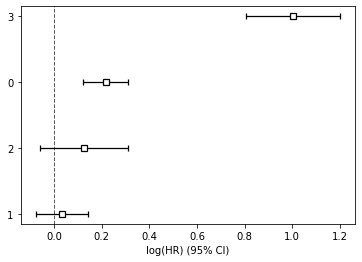

In [359]:
cph.plot()

In [360]:
# Plot the survival function :
d_data = df.iloc[0:5,:]
cph.predict_survival_function(d_data).plot()

KeyError: "None of [Int64Index([0, 1, 2, 3], dtype='int64')] are in the [columns]"

In [42]:
#predict survival probability at specific times: 
cph.predict_survival_function(d_data, [4.25,4.75])

,0,1,2,3,4
4.25,0.525091,0.153013,0.691225,0.532031,0.575837
4.75,0.493081,0.127387,0.666745,0.500239,0.545626


In [43]:
cph.predict_median(d_data)

0    4.62
1    1.31
2     inf
3    4.76
4     inf
Name: 0.5, dtype: float64

In [ ]:
# It represents median time of survival :
#CTE = kmf.conditional_time_to_event_
#plt.plot(CTE)

In [ ]:
axes = cph.check_assumptions(df[["age","bmi","gender","hyp","time","event"]], show_plots=0)

https://sophiamyang.github.io/DS/survival/survivalanalysis.html

The survival probability calibration plot compares simulated data based on your model and the observed data. It provides a straightforward view on how your model fit and deviate from the real data. This is implemented in lifelines lifelines.survival_probability_calibration function.

In [ ]:
print(cph.concordance_index_, cph.log_likelihood_)

In [ ]:
scores = k_fold_cross_validation(cph, 
                                 df[["age","bmi","gender","hyp","time","event"]], 
                                 'time', event_col='event', 
                                 k=5, scoring_method="concordance_index")
print(scores, np.mean(scores))

In [ ]:
print(round(np.mean(scores),4), round(np.std(scores),4))

ICI =  0.00747400972396021
E50 =  0.004998437768661823


(<AxesSubplot:title={'center':'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 5 mortality'}, xlabel='Predicted probability of \nt ≤ 5 mortality', ylabel='Observed probability of \nt ≤ 5 mortality'>, 0.00747400972396021, 0.004998437768661823)

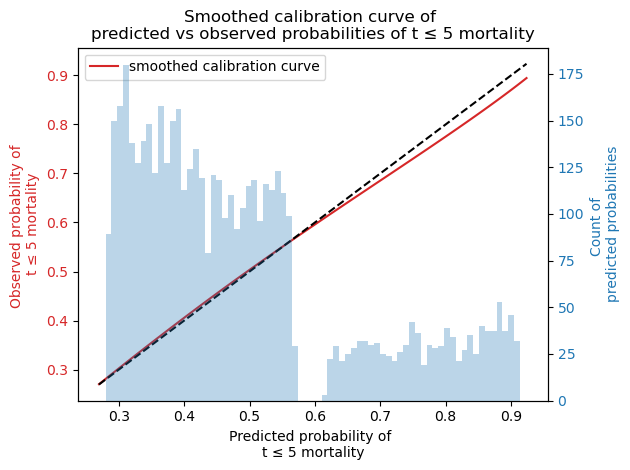

In [191]:
survival_probability_calibration(cph, df, 5)